# Valuing off-ball actions

## Importing libraries

In [1]:
from mplsoccer import Sbopen
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import random as rn

# Importing machine learning libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Setting random seeds so that the results are reproducible on the webpage
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Expected goals including player positions

### Opening data

In [2]:
# Instantiating parser
parser = Sbopen()

# Getting list of games during an Indian Super League season
df_match = parser.match(competition_id=1238, season_id=108)

# Getting match ids
matches = df_match.match_id.unique()

# Instantiating empty dataframes for shots and tracks
shot_df = pd.DataFrame()
track_df = pd.DataFrame()

# Filling them
for match in matches:
    # Opening events
    df_event = parser.event(match)[0]
    
    # Opening 360 data
    df_track = parser.event(match)[2]
    
    # Getting shots and changing yards to meters
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    
    # Getting tracks and changing yards to meters
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)
    
    # Adding them at the end of dataframes
    shot_df = pd.concat([shot_df, shots], ignore_index = True)
    track_df = pd.concat([track_df, df_track], ignore_index = True)

# Resetting indicies
shot_df.reset_index(drop=True, inplace=True)
track_df.reset_index(drop=True, inplace=True)

# Filtering out non open-play shots
shot_df = shot_df.loc[shot_df["sub_type_name"] == "Open Play"]

# Filtering out shots where goalkeeper was not tracked
gks_tracked = track_df.loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"]['id'].unique()
shot_df = shot_df.loc[shot_df["id"].isin(gks_tracked)]

### Feature engineering

In [3]:
# Keeping important variables from shot dataframe
model_vars = shot_df[["id", "index", "x", "y"]]

# Getting the dependent variable
model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)

# Changing the dependent variable to object for basic xG modelling
model_vars["goal_smf"] = model_vars["goal"].astype(object)

# Getting the ball location (x)
model_vars['x0'] = model_vars.x

# Calculating angle and distance
model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)

# Calculating angle and distance between ball and the goal as in Lesson 2
model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))

# Calculating angle and distance as in Lesson 2
model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)

# Calculating basic xG using logistic regression
def params(df):
    test_model = smf.glm(formula="goal_smf ~ angle + distance", data=df, family=sm.families.Binomial()).fit()
    # Printing summary
    return test_model.params

def calculate_xG(sh, b):
    bsum=b[0]
    for i,v in enumerate(["angle", "distance"]):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum))
    return xG

# Calculating expected goals based on distance to goal and angle between the ball and the goal
b = params(model_vars)
model_vars["xg_basic"]= model_vars.apply(calculate_xG, b = b, axis=1)

# Calculating ball-goalkeeper distance
def dist_to_gk(test_shot, track_df):
    # Getting id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # Checking goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    # Calculating distance from event to goalkeeper position
    dist = np.sqrt((test_shot["x"] - gk_pos["x"])**2 + (test_shot["y"] - gk_pos["y"])**2)
    return dist.iloc[0]

# Storing distance from event to goalkeeper position in a dataframe
model_vars["gk_distance"] = shot_df.apply(dist_to_gk, track_df = track_df, axis = 1)


# Calculating ball-goalkeeper y axis
def y_to_gk(test_shot, track_df):
    # Getting id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # Calculating distance from event to goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["y"]]
    # Calculating distance from event to goalkeeper position in y axis
    dist = abs(test_shot["y"] - gk_pos["y"])
    return dist.iloc[0]

# Storing distance in y axis from event to goalkeeper position in a dataframe
model_vars["gk_distance_y"] = shot_df.apply(y_to_gk, track_df = track_df, axis = 1)

# Checking the number of players less than 3 meters away from the ball
def three_meters_away(test_shot, track_df):
    # Getting id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # Getting all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    # Calculating their distance to the ball
    dist = np.sqrt((test_shot["x"] - player_position["x"])**2 + (test_shot["y"] - player_position["y"])**2)
    # Returning how many are closer to the ball than 3 meters
    return len(dist[dist<3])

# Storing number of opposition's players closer than 3 meters in a dataframe
model_vars["close_players"] = shot_df.apply(three_meters_away, track_df = track_df, axis = 1)

# Checking the number of players inside a triangle
def players_in_triangle(test_shot, track_df):
    # Getting id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # Getting all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    # Checking if point inside a triangle
    x1 = 105
    y1 = 34 - 7.32/2
    x2 = 105
    y2 = 34 + 7.32/2
    x3 = test_shot["x"]
    y3 = test_shot["y"]
    xp = player_position["x"]
    yp = player_position["y"]
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1)
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2)
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3)
    # Getting number of players inside a triangle
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])

# Storing number of opposition's players inside a triangle in a dataframe
model_vars["triangle"] = shot_df.apply(players_in_triangle, track_df = track_df, axis = 1)

#Calculating goalkeeper distance to goal
def gk_dist_to_goal(test_shot, track_df):
    # Getting id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    # Getting goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    # Calculating their distance to goal
    dist = np.sqrt((105 -gk_pos["x"])**2 + (34 - gk_pos["y"])**2)
    return dist.iloc[0]

# Storing opposition's goalkeeper distance to goal in a dataframe
model_vars["gk_dist_to_goal"] = shot_df.apply(gk_dist_to_goal, track_df = track_df, axis = 1)

# Creating binary varibale 1 if ball is closer to the goal than goalkeeper
model_vars["is_closer"] = np.where(model_vars["gk_dist_to_goal"] > model_vars["distance"], 1, 0)

# Creating binary variable 1 if header
model_vars["header"] = shot_df.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)

# Storing dependent variable in a numpy array
y = model_vars["goal"].values

# Storing independent variables in a numpy array
X = model_vars[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values

### Training neural network

Epoch 1/1000
108/108 [==============================] - 2s 7ms/step - loss: 0.1639 - accuracy: 0.8794 - val_loss: 0.1098 - val_accuracy: 0.8974
Epoch 2/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.1017 - accuracy: 0.8974 - val_loss: 0.0928 - val_accuracy: 0.8974
Epoch 3/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.8974 - val_loss: 0.0894 - val_accuracy: 0.8974
Epoch 4/1000
108/108 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.8974 - val_loss: 0.0864 - val_accuracy: 0.8974
Epoch 5/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0896 - accuracy: 0.8974 - val_loss: 0.0837 - val_accuracy: 0.8974
Epoch 6/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.8974 - val_loss: 0.0810 - val_accuracy: 0.8974
Epoch 7/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.8980 - val_loss: 0.0790 - val_accuracy:

108/108 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9043 - val_loss: 0.0762 - val_accuracy: 0.9113
Epoch 58/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9032 - val_loss: 0.0764 - val_accuracy: 0.9130
Epoch 59/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9032 - val_loss: 0.0766 - val_accuracy: 0.9113
Epoch 60/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9043 - val_loss: 0.0764 - val_accuracy: 0.9130
Epoch 61/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0798 - accuracy: 0.9038 - val_loss: 0.0763 - val_accuracy: 0.9130
Epoch 62/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9038 - val_loss: 0.0763 - val_accuracy: 0.9148
Epoch 63/1000
108/108 [==============================] - 0s 4ms/step - loss: 0.0797 - accuracy: 0.9049 - val_loss: 0.0764 - val_accuracy: 0.9130

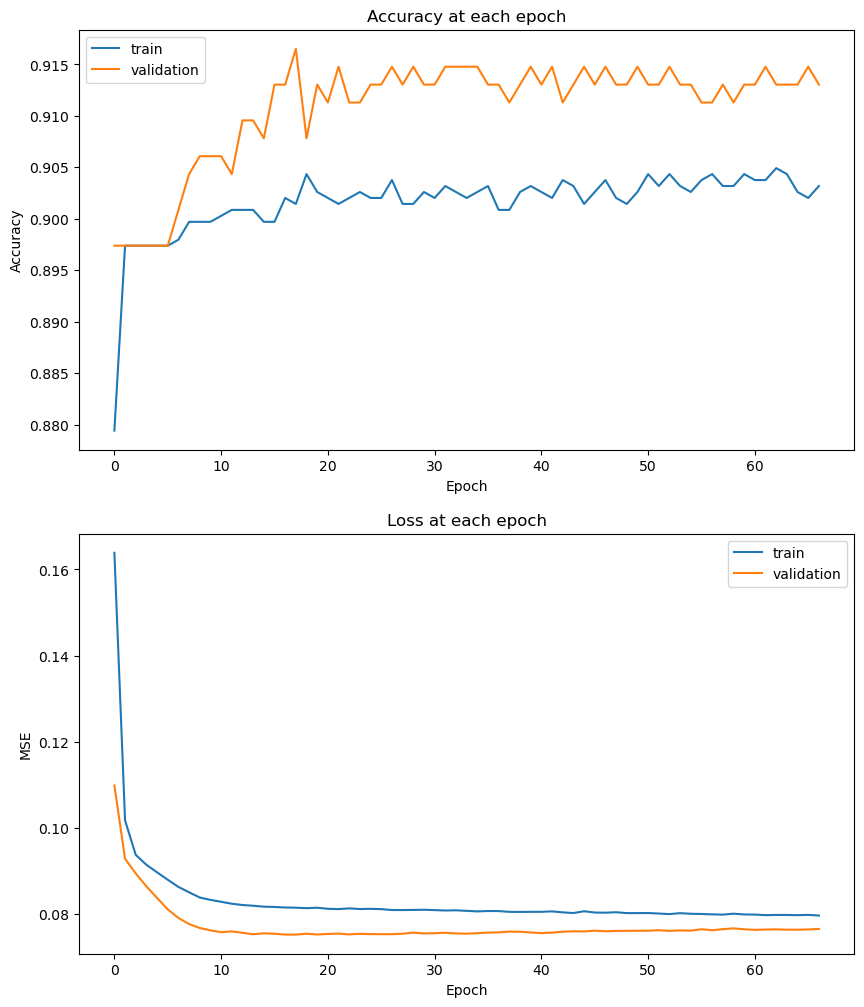

In [4]:
# Spliting the data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)

# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_cal = scaler.transform(X_cal)

# Creating a function with a model architecture
def create_model():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss="mean_squared_error" , metrics=['accuracy'])
    return model

# Instantiating model
model = create_model()

# Creating an early stopping object
callback = EarlyStopping(min_delta=1e-5, patience = 50, mode = "min", monitor = "val_loss", restore_best_weights=True)

# Fitting the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=16, callbacks = [callback])

# Subplotting the display
fig, axs = plt.subplots(2, figsize=(10,12))

# Plotting training history - accuracy
axs[0].plot(history.history['accuracy'], label='train')
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plotting training history - loss function
axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
plt.show()

### Assessing the model

18/18 [==============================] - 0s 1ms/step


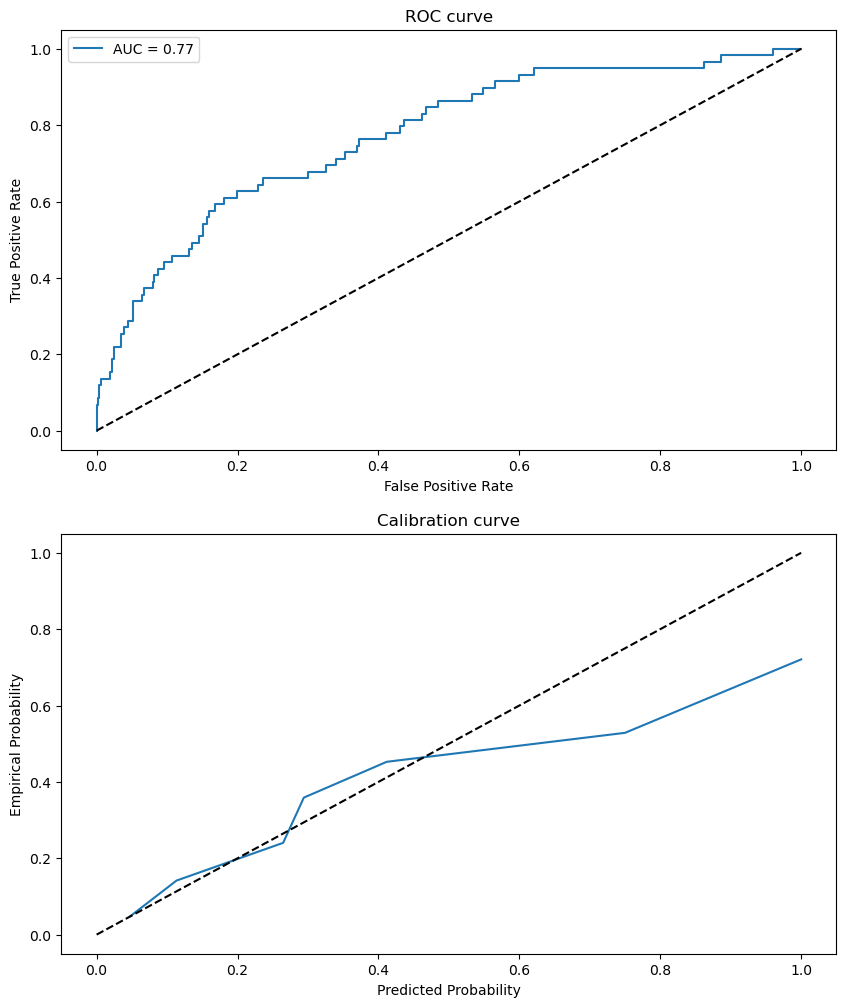

Brier score 0.0800676395873302


In [5]:
# Plotting ROC curve
fig, axs = plt.subplots(2, figsize=(10,12))
y_pred = model.predict(X_cal)
fpr, tpr, _ = roc_curve(y_cal,  y_pred)
auc = roc_auc_score(y_cal, y_pred)
axs[0].plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
axs[0].plot([0, 1], [0, 1], color='black', ls = '--')
axs[0].legend()
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title('ROC curve')

# Plotting calibration curve
prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10)
axs[1].plot(prob_true, prob_pred)
axs[1].plot([0, 1], [0, 1], color='black', ls = '--')
axs[1].set_ylabel('Empirical Probability')
axs[1].set_xlabel('Predicted Probability')
axs[1].set_title("Calibration curve")
plt.show()

# Printing Brier score
print("Brier score", brier_score_loss(y_cal, y_pred))

### Calculating xG using the model during UEFA Euro 2020

In [6]:
# Getting trackings and events for UEFA Euro
df_match2 = parser.match(competition_id=55, season_id=43)

# Getting array of match ids, shots and tracks
matches2 = df_match2.match_id.unique()
shot_df2 = pd.DataFrame()
track_df2 = pd.DataFrame()

# Storing shots and trackings in dataframes for the entire season
for match in matches2:
    df_event = parser.event(match)[0]
    df_track = parser.event(match)[2]
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)

    shot_df2 = pd.concat([shot_df2, shots], ignore_index = True)
    track_df2 = pd.concat([track_df2, df_track], ignore_index = True)

# Resetting indicies and remove shots that were not open play or when the goalkeeper was not tracked
shot_df2 = shot_df2.loc[shot_df2["sub_type_name"] == "Open Play"]
shot_df2.reset_index(drop=True, inplace=True)
track_df2.reset_index(drop=True, inplace=True)
gks_tracked2 = track_df2.loc[track_df2["teammate"] == False].loc[track_df2["position_name"] == "Goalkeeper"]['id'].unique()
shot_df2 = shot_df2.loc[shot_df2["id"].isin(gks_tracked2)]

# Wrangling data
model_vars2 = shot_df2[["id", "index", "x", "y"]]
model_vars2["goal"] = shot_df2.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
model_vars2["goal_smf"] = model_vars2["goal"].astype(object)
model_vars2['x0'] = model_vars2.x
model_vars2["x"] = model_vars2.x.apply(lambda cell: 105-cell)
model_vars2["c"] = model_vars2.y.apply(lambda cell: abs(34-cell))
model_vars2["angle"] = np.where(np.arctan(7.32 * model_vars2["x"] / (model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars2["distance"] = np.sqrt(model_vars2["x"]**2 + model_vars2["c"]**2)
model_vars2["xg_basic"]= model_vars2.apply(calculate_xG, b = b, axis=1)
model_vars2["gk_distance"] = shot_df2.apply(dist_to_gk, track_df = track_df2, axis = 1)
model_vars2["gk_distance_y"] = shot_df2.apply(y_to_gk, track_df = track_df2, axis = 1)
model_vars2["triangle"] = shot_df2.apply(players_in_triangle, track_df = track_df2, axis = 1)
model_vars2["close_players"] = shot_df2.apply(three_meters_away, track_df = track_df2, axis = 1)
model_vars2["gk_dist_to_goal"] = shot_df2.apply(gk_dist_to_goal, track_df = track_df2, axis = 1)
model_vars2["is_closer"] = np.where(model_vars2["gk_dist_to_goal"] > model_vars2["distance"], 1, 0)
model_vars2["header"] = shot_df2.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)

# Storing data in a matrix
X_unseen = model_vars2[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values

# Scaling data
X_unseen = scaler.transform(X_unseen)

# Making predictions
xgs_euro = model.predict(X_unseen)

# Finding out which 5 players had the highest xG
shot_df2["our_xG"] = xgs_euro
shot_df2.groupby(["player_name"])["our_xG"].sum().sort_values(ascending = False)[:5].reset_index()

38/38 [==============================] - 0s 2ms/step


,player_name,our_xG
0,Álvaro Borja Morata Martín,2.843987
1,Harry Kane,2.615587
2,Cristiano Ronaldo dos Santos Aveiro,2.379563
3,Kai Havertz,2.312685
4,Gerard Moreno Balaguero,2.243831
